In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model

In [2]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [3]:
img_size = (224, 224)
input_shape = img_size + (3,)
num_classes = 40
batch_size = 32

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory='datasets/train',
  label_mode="categorical",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  directory='datasets/val',
  shuffle=False,
  label_mode="categorical",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  shuffle=False,
  directory='datasets/test',
  label_mode="categorical",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.


Found 1034 files belonging to 3 classes.


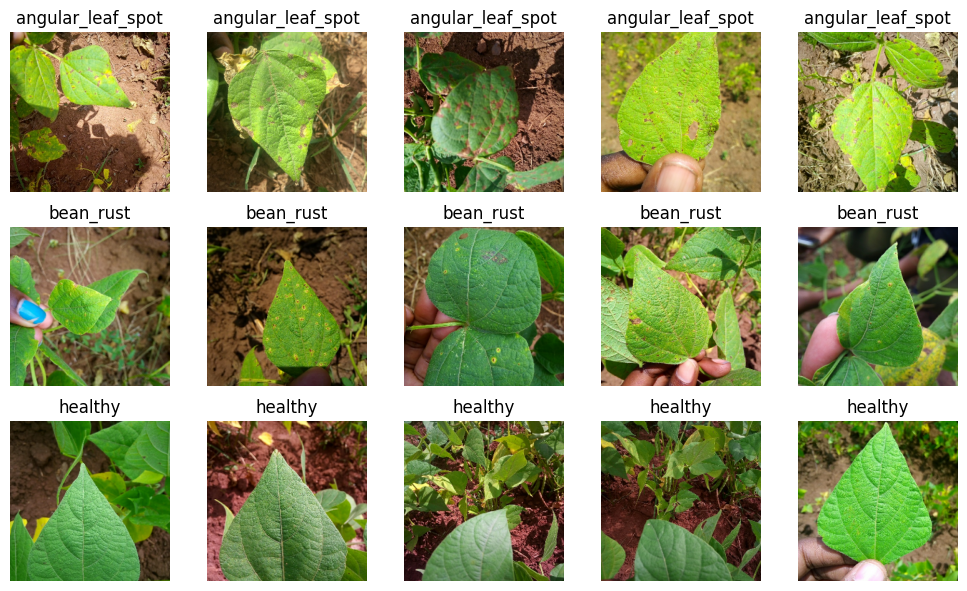

In [5]:
data_temp = tf.keras.utils.image_dataset_from_directory(
    directory='datasets/train',
    batch_size=5,
    shuffle=False,
    seed=123,
)

class_names = data_temp.class_names

fig, axes = plt.subplots(3, 5, figsize=(10,6))
axes = axes.flatten()

for i, cls in enumerate(class_names):
    j = 0
    
    for img, label in data_temp:
        if label[0] == i:
            ax = axes[i*5 + j]
            ax.imshow(img[0].numpy().astype("uint8"))
            ax.set_title(cls)
            ax.axis('off')
            j += 1
            if j == 5:
                break
                
plt.tight_layout()
plt.show()


In [6]:
y_test_true = np.concatenate([y for x, y in test_ds], axis=0)
y_test_true = np.argmax(y_test_true, axis=-1)

In [7]:
mobilenet_model = MobileNetV3Small(weights='imagenet', 
                        include_top=False, 
                        input_shape=input_shape)

for layer in mobilenet_model.layers:
    layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(mobilenet_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.models.Model(inputs=mobilenet_model.input, outputs=predictions)

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

In [9]:
checkpoint_path = "models/best_mobilenetv3.h5"
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

In [10]:
history = model.fit(train_ds, validation_data=val_ds, epochs=25, callbacks=[model_checkpoint, early_stopping])

Epoch 1/25
32/33 [============================>.] - ETA: 0s - loss: 0.7781 - accuracy: 0.6660
Epoch 1: val_accuracy improved from -inf to 0.86466, saving model to models\best_mobilenetv3.h5
33/33 [==============================] - 11s 92ms/step - loss: 0.7772 - accuracy: 0.6663 - val_loss: 0.3721 - val_accuracy: 0.8647
Epoch 2/25
32/33 [============================>.] - ETA: 0s - loss: 0.4409 - accuracy: 0.8164
Epoch 2: val_accuracy improved from 0.86466 to 0.92481, saving model to models\best_mobilenetv3.h5
33/33 [==============================] - 1s 33ms/step - loss: 0.4434 - accuracy: 0.8162 - val_loss: 0.2884 - val_accuracy: 0.9248
Epoch 3/25
30/33 [==========================>...] - ETA: 0s - loss: 0.3476 - accuracy: 0.8583
Epoch 3: val_accuracy did not improve from 0.92481
33/33 [==============================] - 1s 22ms/step - loss: 0.3481 - accuracy: 0.8559 - val_loss: 0.2671 - val_accuracy: 0.8872
Epoch 4/25
32/33 [============================>.] - ETA: 0s - loss: 0.2831 - accu

In [11]:
final_model = tf.keras.models.load_model("models/best_mobilenetv3.h5")

In [12]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv("history/history_mobilenetv3.csv", index=False)

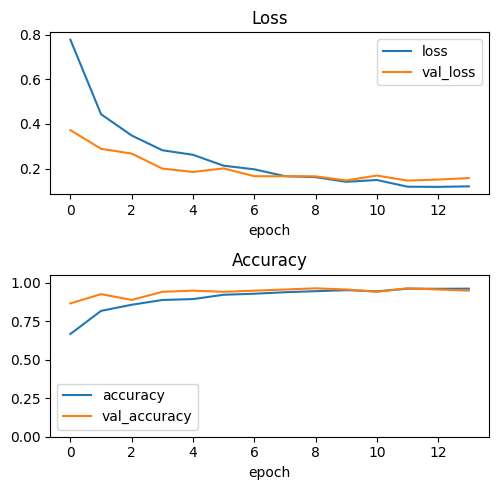

In [13]:
history_df = pd.read_csv("history/history_mobilenetv3.csv")

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(211)
ax1.set_title('Loss')
ax1.plot(history_df['loss'], label='loss')
ax1.plot(history_df['val_loss'], label='val_loss')
ax1.set_xlabel("epoch")
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.set_title('Accuracy')
ax2.plot(history_df['accuracy'], label='accuracy')
ax2.plot(history_df['val_accuracy'], label='val_accuracy')
ax2.set_xlabel("epoch")
ax2.legend()
ax2.set_ylim(0, 1.05) 

plt.tight_layout()
plt.show()

In [14]:
y_test_pred = np.argmax(final_model.predict(test_ds), axis=-1)

4/4 [==============================] - 1s 19ms/step


In [15]:
def format_percent(val):
    return "{:.2f}%".format(val * 100)

In [16]:
report = classification_report(y_test_true, y_test_pred, digits=4, output_dict=True)
class_report = pd.DataFrame(report).transpose()
class_report.iloc[:, :3] = class_report.iloc[:, :3].applymap(lambda x: x * 100)
class_report = class_report.style.format("{:.2f}", subset=pd.IndexSlice[:, ['precision', 'recall', 'f1-score']])\
                              .format("{:.0f}", subset=pd.IndexSlice[:, ['support']])
class_report


,precision,recall,f1-score,support
0,87.23,95.35,91.11,43
1,90.48,88.37,89.41,43
2,100.00,92.86,96.30,42
accuracy,92.19,92.19,92.19,1
macro avg,92.57,92.19,92.27,128
weighted avg,92.51,92.19,92.24,128


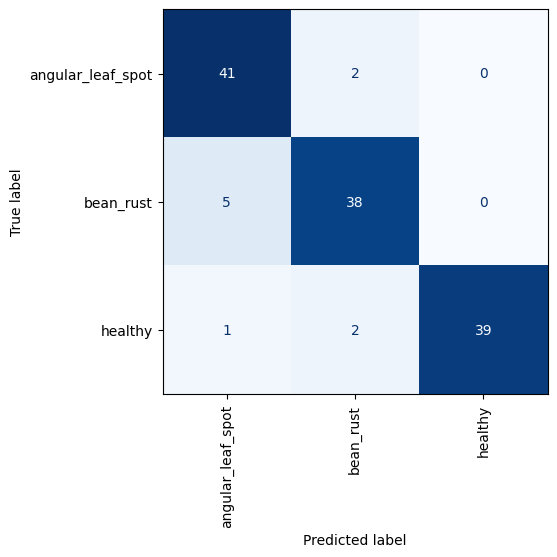

In [17]:
class_names = test_ds.class_names
conf = confusion_matrix(y_test_true, y_test_pred)
disp = ConfusionMatrixDisplay(conf, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=False)
plt.show()